In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np

import optuna 

import torch
from torch.utils.data import DataLoader
import torch.utils.data as data_utils
from torch.optim import SGD, Adam

import matplotlib.pyplot as plt
# plt.rcParams['figure.facecolor'] = 'white'

from datasets import get_dataset
from loss_fns import get_loss
from utils import solve

torch.set_default_dtype(torch.float64)

%load_ext line_profiler

/home/farshed.abdukhakimov/.conda/envs/sps2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

In [3]:
def logistic_reg(w, X, y):
    return torch.mean(torch.log(1 + torch.exp(-y * (X @ w))))

def nllsq(w, X, y):
    return torch.mean( ( y - (1/(1 + torch.exp(-X @ w ))) )**2 )

def rademacher_old(weights):
    return torch.round(torch.rand_like(weights)) * 2 - 1

def diag_estimate_old(weights, grad, iters):
    Ds = []
    for j in range(iters):
        z = rademacher_old(weights)
        with torch.no_grad():
            hvp = torch.autograd.grad(grad, weights, grad_outputs=z, retain_graph=True)[0]
        Ds.append((hvp*z))

    return torch.mean(torch.stack(Ds), 0)

In [4]:
# Setup
batch_size = 64
dataset_name = "mushrooms"
percentage = 1.0

# training 
STEPS = 300
loss_name = "logreg"
loss_class = get_loss(loss_name)
gamma = 1.0 

torch.random.manual_seed(0)

scale_k = 0
scale_range = [-scale_k, scale_k] # [-value, value]
train_data, train_target = get_dataset(dataset_name, batch_size, percentage, scale_range, loss_class.y_range)
train_data = train_data.to(torch.get_default_dtype())
train_target = train_target.to(torch.get_default_dtype())
train_load = data_utils.TensorDataset(train_data, train_target)
train_dataloader = DataLoader(train_load, batch_size=batch_size, shuffle=True)

/home/farshed.abdukhakimov/projects/sps2/datasets


# SGD

In [5]:
# study_name = f"sgd-{dataset_name}-{batch_size}-{percentage}-{STEPS}-{loss_name}-{scale_k}"
# storage_name = "sqlite:///optuna_results/{}.db".format(study_name)
# study = optuna.load_study(study_name=study_name, storage=storage_name)
# lr = study.best_params["lr"]
lr = 0.1

# parameters
w = torch.zeros(train_data.shape[1], device=device).requires_grad_()
optimizer = SGD([w], lr=lr)
loss_function = loss_class(w)

# save loss and grad size to history
hist_sgd = []
loss = loss_function(train_data.to(device), train_target.to(device))
g, = torch.autograd.grad(loss, w, create_graph=True)
print(f"Loss: {loss.item()} | GradNorm^2: {(torch.linalg.norm(g) ** 2 ).item()}")
hist_sgd.append([loss.item(), (torch.linalg.norm(g) ** 2).item()])

for step in range(STEPS):
    for i, (batch_data, batch_target) in enumerate(train_dataloader):
        batch_data = batch_data.to(device)
        batch_target = batch_target.to(device)
        optimizer.zero_grad()
        loss = loss_function(batch_data, batch_target)
        loss.backward()
        optimizer.step()

    loss = loss_function(train_data.to(device), train_target.to(device))
    g, = torch.autograd.grad(loss, w, create_graph=True)
    print(f"Loss: {loss.item()} | GradNorm^2: {(torch.linalg.norm(g) ** 2 ).item()}")
    hist_sgd.append([loss.item(), (torch.linalg.norm(g) ** 2).item()])

Loss: 0.6931471805599453 | GradNorm^2: 0.3195669607542947
Loss: 0.16668382211443877 | GradNorm^2: 0.006134417731569834
Loss: 0.12045682781964252 | GradNorm^2: 0.002328108859702026
Loss: 0.09966336687539232 | GradNorm^2: 0.0012205034950301488
Loss: 0.08716118420808967 | GradNorm^2: 0.0009358335916332891
Loss: 0.07812815748680701 | GradNorm^2: 0.0006071497872857561
Loss: 0.07126480284284004 | GradNorm^2: 0.00048009678411869993
Loss: 0.06573379161270573 | GradNorm^2: 0.00039824453669382704
Loss: 0.06111803873864498 | GradNorm^2: 0.00033293426528437764
Loss: 0.057195072820730816 | GradNorm^2: 0.00028907912910852804
Loss: 0.05379499479938606 | GradNorm^2: 0.0002493395444248656
Loss: 0.05082921393916707 | GradNorm^2: 0.000224283205772718
Loss: 0.04822257353335311 | GradNorm^2: 0.00021325320697692442
Loss: 0.04586555172921916 | GradNorm^2: 0.00018325201400722275
Loss: 0.04374984939160306 | GradNorm^2: 0.00015959331431272022
Loss: 0.04184138103814873 | GradNorm^2: 0.0001433361864275968
Loss: 0

# Adam

In [6]:
# study_name = f"adam-{dataset_name}-{batch_size}-{percentage}-{STEPS}-{loss_name}-{scale_k}"
# storage_name = "sqlite:///optuna_results/{}.db".format(study_name)
# study = optuna.load_study(study_name=study_name, storage=storage_name)
# lr = study.best_params["lr"]
lr = 0.1
# parameters
w = torch.zeros(train_data.shape[1], device=device).requires_grad_()
optimizer = Adam([w], lr=lr)
loss_function = loss_class(w)

# save loss and grad size to history
hist_adam = []
loss = loss_function(train_data.to(device), train_target.to(device))
g, = torch.autograd.grad(loss, w, create_graph=True)
print(f"Loss: {loss.item()} | GradNorm^2: {(torch.linalg.norm(g) ** 2 ).item()}")
hist_adam.append([loss.item(), (torch.linalg.norm(g) ** 2).item()])

for step in range(STEPS):
    for i, (batch_data, batch_target) in enumerate(train_dataloader):
        batch_data = batch_data.to(device)
        batch_target = batch_target.to(device)
        optimizer.zero_grad()
        loss = loss_function(batch_data, batch_target)
        loss.backward()
        optimizer.step()

    loss = loss_function(train_data.to(device), train_target.to(device))
    g, = torch.autograd.grad(loss, w, create_graph=True)
    print(f"Loss: {loss.item()} | GradNorm^2: {(torch.linalg.norm(g) ** 2 ).item()}")
    hist_adam.append([loss.item(), (torch.linalg.norm(g) ** 2).item()])

Loss: 0.6931471805599453 | GradNorm^2: 0.3195669607542947
Loss: 0.007451683507338987 | GradNorm^2: 6.77209635151883e-05
Loss: 0.0030237306847070086 | GradNorm^2: 2.0378028737299437e-06
Loss: 0.0017588199343609911 | GradNorm^2: 9.738784772443405e-07
Loss: 0.0011627772543538863 | GradNorm^2: 1.818614540107884e-07
Loss: 0.0008308262710892498 | GradNorm^2: 6.811354814526095e-08
Loss: 0.0006436656414065681 | GradNorm^2: 1.2197930804677897e-07
Loss: 0.0005216601601498042 | GradNorm^2: 2.1559517620680685e-07
Loss: 0.00041703377114478814 | GradNorm^2: 8.872391719205328e-08
Loss: 0.0003414416628798521 | GradNorm^2: 1.7086761118074086e-08
Loss: 0.00029295256507511883 | GradNorm^2: 4.7659498759754054e-08
Loss: 0.00024767622735338623 | GradNorm^2: 2.1550591778265113e-08
Loss: 0.00021140142124728684 | GradNorm^2: 4.487284698447492e-09
Loss: 0.00018944216949432044 | GradNorm^2: 2.3665297665058975e-08
Loss: 0.00016286925342249157 | GradNorm^2: 4.656227761564756e-09
Loss: 0.00014669636521912784 | Grad

# PSPS2
$w^* = \arg\min_{w\in\mathbb{R} ^d}\frac{1}{2} \|w - w_t\|_{D}^2 \nonumber \\
\textit{s.t.} \quad f_i(w_t) +  \langle  \nabla  f_i(w_t), w-w_t \rangle + \frac{1}{2} \langle D(w-w^t), w - w^t \rangle = 0$

In [7]:
# parameters
alpha = 1e-4
beta=0.999
w = torch.zeros(train_data.shape[1], device=device).requires_grad_()

loss_function = loss_class(w)

# save loss and grad size to history
hist_psps2 = []
loss = loss_function(train_data.to(device), train_target.to(device))
g, = torch.autograd.grad(loss, w, create_graph=True)
print(f"Loss: {loss.item()} | GradNorm^2: {(torch.linalg.norm(g) ** 2 ).item()}")
hist_psps2.append([loss.item(), (torch.linalg.norm(g) ** 2).item()])

# preconditioninig matrix
Dk = diag_estimate_old(w, g, 100)
Dk_hat_inv = torch.ones_like(w)


for step in range(STEPS):

    for i, (batch_data, batch_target) in enumerate(train_dataloader):

        batch_data = batch_data.to(device)
        batch_target = batch_target.to(device)

        loss = loss_function(batch_data, batch_target)
        g, = torch.autograd.grad(loss, w, create_graph=True)

        vk = diag_estimate_old(w, g, 1)

        # Smoothing and Truncation 
        Dk = beta * Dk + (1 - beta) * vk
        Dk_hat = torch.abs(Dk)
        Dk_hat[Dk_hat < alpha] = alpha

        Dk_hat_inv = 1 / Dk_hat

        gnorm = (g * Dk_hat_inv).dot(g)

        f_grad = g.clone().detach()
        
        a = 2 * loss.item() + 3 * gnorm
        b = 4 * loss.item() - 2 * gnorm
        c = 2 * loss.item()

        det = 1 - (2 * loss.item() / gnorm )

        if det < 1e-15:
            # print("no real solution")
            continue
        else:
            t = torch.sqrt(det)/det
            root1 = -1 + t
            root2 = -1 - t
            
            root = torch.maximum(root1, root2)

        precond = root/(1 + root) * Dk_hat_inv
        with torch.no_grad():
            w.sub_(precond * f_grad)

    loss = loss_function(train_data.to(device), train_target.to(device))
    g, = torch.autograd.grad(loss, w, create_graph=True)
    print(f"Loss: {loss.item()} | GradNorm^2: {(torch.linalg.norm(g) ** 2 ).item()}")
    hist_psps2.append([loss.item(), (torch.linalg.norm(g) ** 2).item()])

Loss: 0.6931471805599453 | GradNorm^2: 0.3195669607542947
Loss: 0.01273632985658148 | GradNorm^2: 4.8047184393537585e-05
Loss: 0.011085717156693133 | GradNorm^2: 7.900462273791814e-05
Loss: 0.011570226701282608 | GradNorm^2: 0.0005507484889951745
Loss: 0.006942764910307914 | GradNorm^2: 9.319190015826484e-05
Loss: 0.005942196459627987 | GradNorm^2: 7.085505782630452e-05
Loss: 0.004286356016590375 | GradNorm^2: 3.763538784024932e-05
Loss: 0.004215666015102859 | GradNorm^2: 3.74723944443412e-05
Loss: 0.0038063931156914125 | GradNorm^2: 6.94737066862079e-05
Loss: 0.002831080588959166 | GradNorm^2: 4.673096638043763e-06
Loss: 0.002831080588959166 | GradNorm^2: 4.673096638043763e-06
Loss: 0.0023829953969756864 | GradNorm^2: 1.4857996916270562e-05
Loss: 0.0020960760876296398 | GradNorm^2: 4.786921326293024e-06
Loss: 0.0021211250939524597 | GradNorm^2: 1.5368743628067295e-05
Loss: 0.0015620632739325921 | GradNorm^2: 1.8387322542095513e-06
Loss: 0.0015620632739325921 | GradNorm^2: 1.8387322542

# PSPS2-L1
$w_{t+1}, \; s_{t+1} = {\arg\min}_{w\in\mathbb{R}^d,s\geq
    0}\frac{1}{2}\|w-w_t\|_{D}^2+\mu(s-s_t)^2+\lambda s \nonumber \\
    \textit{s.t.} \quad f_i(w_t) +  \langle  \nabla  f_i(w_t), w-w_t\rangle +\frac{1}{2}\langle D(w-w^t), w - w^t \rangle \leq s \nonumber.$

In [8]:
# parameters
alpha = 1e-4
beta=0.999
w = torch.zeros(train_data.shape[1], device=device).requires_grad_()
s = torch.tensor(0.0)
lmd = 0.01
mu = 0.1

loss_function = loss_class(w)

# save loss and grad size to history
hist_psps2_l1 = []
loss = loss_function(train_data.to(device), train_target.to(device))
g, = torch.autograd.grad(loss, w, create_graph=True)
print(f"Loss: {loss.item()} | GradNorm^2: {(torch.linalg.norm(g) ** 2 ).item()}")
hist_psps2_l1.append([loss.item(), (torch.linalg.norm(g) ** 2).item(), s])

# preconditioninig matrix
Dk = diag_estimate_old(w, g, 100)

for step in range(STEPS):

    for i, (batch_data, batch_target) in enumerate(train_dataloader):

        batch_data = batch_data.to(device)
        batch_target = batch_target.to(device)

        loss = loss_function(batch_data, batch_target)

        s_nil = s - (lmd/(2*mu))
        z = s - s_nil
        
        if (i != 0) and s_nil >= loss.item():
            continue

        g, = torch.autograd.grad(loss, w, create_graph=True)

        vk = diag_estimate_old(w, g, 1)

        # Smoothing and Truncation 
        Dk = beta * Dk + (1 - beta) * vk
        Dk_hat = torch.abs(Dk)
        Dk_hat[Dk_hat < alpha] = alpha

        Dk_hat_inv = 1 / Dk_hat

        gnorm = (g * Dk_hat_inv).dot(g)

        f_grad = g.clone().detach()

        if gnorm < 1e-8:
            continue

        t = loss.item() - s_nil
        a = torch.dot(f_grad, Dk_hat_inv*f_grad).cpu().detach().numpy()
        
        AA = 1
        BB = 2 + mu * a - 2 * mu * t
        CC = 1 + 2 * mu * a - 4 * mu * t
        DD = -2 * mu * t

        roots = solve(AA, BB, CC, DD)
        roots = torch.from_numpy(roots)      
        root_star = torch.relu(torch.max(roots))

        s = torch.relu(s - ((lmd - root_star)/2 * mu)).item()
    
        precond = root_star/(1 + root_star) * Dk_hat_inv    
        with torch.no_grad():
            w.sub_(precond  * f_grad)

    loss = loss_function(train_data.to(device), train_target.to(device))
    g, = torch.autograd.grad(loss, w, create_graph=True)
    print(f"Loss: {loss.item()} | GradNorm^2: {(torch.linalg.norm(g) ** 2 ).item()} | s: {s} | s_nil + z = {s_nil + z}")
    hist_psps2_l1.append([loss.item(), (torch.linalg.norm(g) ** 2).item(), s])

Loss: 0.6931471805599453 | GradNorm^2: 0.3195669607542947
Loss: 0.04319362217204191 | GradNorm^2: 0.000695710077354812 | s: 0.04605122658256474 | s_nil + z = 0.04613842921629544
Loss: 0.029801985379582133 | GradNorm^2: 0.00035695849121140976 | s: 0.037211649691514484 | s_nil + z = 0.03735630166475626
Loss: 0.022423024203195106 | GradNorm^2: 0.00014168968915972597 | s: 0.028501710642390217 | s_nil + z = 0.028495870536985896
Loss: 0.017675602757730637 | GradNorm^2: 9.067517599499067e-05 | s: 0.02198859855713457 | s_nil + z = 0.021948729514747082
Loss: 0.014327681732857707 | GradNorm^2: 5.212456030260763e-05 | s: 0.017395247354635685 | s_nil + z = 0.01745097704478775
Loss: 0.011889782767921863 | GradNorm^2: 3.7404675760447914e-05 | s: 0.013941430742712672 | s_nil + z = 0.01396672173785539
Loss: 0.010015060695152048 | GradNorm^2: 2.4387564270917618e-05 | s: 0.011516611275693698 | s_nil + z = 0.01156383192918023
Loss: 0.008546059209057402 | GradNorm^2: 1.669923030975711e-05 | s: 0.009506467

# PSPS2-L2
$w_{t+1}, \; s_{t+1} = {\arg\min}_{w\in\mathbb{R}^d,s\geq
    0}\frac{1}{2}\|w-w_t\|_{D}^2+\mu(s-s_t)^2+\lambda s^2 \nonumber \\
    \textit{s.t.} \quad f_i(w_t) +  \langle  \nabla  f_i(w_t), w-w_t\rangle +\frac{1}{2}\langle D(w-w^t), w - w^t \rangle \leq s \nonumber.$

In [9]:
# parameters
alpha = 1e-4
beta=0.999
w = torch.zeros(train_data.shape[1], device=device).requires_grad_()
s = torch.tensor(0.0)
lmd = 0.01
mu = 0.1
delta = lmd + mu

loss_function = loss_class(w)

# save loss and grad size to history
hist_psps2_l2 = []
loss = loss_function(train_data.to(device), train_target.to(device))
g, = torch.autograd.grad(loss, w, create_graph=True)
print(f"Loss: {loss.item()} | GradNorm^2: {(torch.linalg.norm(g) ** 2 ).item()}")
hist_psps2_l2.append([loss.item(), (torch.linalg.norm(g) ** 2).item(), s])

# preconditioninig matrix
Dk = diag_estimate_old(w, g, 100)

for step in range(STEPS):

    for i, (batch_data, batch_target) in enumerate(train_dataloader):

        batch_data = batch_data.to(device)
        batch_target = batch_target.to(device)

        loss = loss_function(batch_data, batch_target)

        s_nil = s - (lmd/(2*mu))
        z = s - s_nil
        
        if (i != 0) and s_nil >= loss.item():
            continue

        g, = torch.autograd.grad(loss, w, create_graph=True)

        vk = diag_estimate_old(w, g, 1)

        # Smoothing and Truncation 
        Dk = beta * Dk + (1 - beta) * vk
        Dk_hat = torch.abs(Dk)
        Dk_hat[Dk_hat < alpha] = alpha

        Dk_hat_inv = 1 / Dk_hat

        gnorm = (g * Dk_hat_inv).dot(g)

        f_grad = g.clone().detach()

        if gnorm < 1e-8:
            continue

        t = loss.item() - s_nil
        a = torch.dot(f_grad, Dk_hat_inv*f_grad).cpu().detach().numpy()
        
        AA = 1
        BB = 2 + delta * a - 2 * delta * t
        CC = 1 + 2 * delta * a - 4 * delta * t
        DD = -2 * delta * t

        roots = solve(AA, BB, CC, DD)
        roots = torch.from_numpy(roots)      
        root_star = torch.relu(torch.max(roots))

        s = (1/delta) * (mu * s + (root_star/2)).item()
        
        precond = root_star/(1 + root_star) * Dk_hat_inv    
        with torch.no_grad():
            w.sub_(precond  * f_grad)

    loss = loss_function(train_data.to(device), train_target.to(device))
    g, = torch.autograd.grad(loss, w, create_graph=True)
    print(f"Loss: {loss.item()} | GradNorm^2: {(torch.linalg.norm(g) ** 2 ).item()} | s: {s} | s_nil + z = {s_nil + z}")
    hist_psps2_l2.append([loss.item(), (torch.linalg.norm(g) ** 2).item(), s])

Loss: 0.6931471805599453 | GradNorm^2: 0.3195669607542947
Loss: 0.16013198383282606 | GradNorm^2: 0.012247448263255791 | s: 0.19640301909294672 | s_nil + z = 0.19640301909294672
Loss: 0.13203825285636958 | GradNorm^2: 0.00864781459206309 | s: 0.21521931024640883 | s_nil + z = 0.21521931024640883
Loss: 0.10469870631126875 | GradNorm^2: 0.005025258623112497 | s: 0.1703300259840491 | s_nil + z = 0.1703300259840491
Loss: 0.09629874630104282 | GradNorm^2: 0.004741101845501772 | s: 0.18052491445703026 | s_nil + z = 0.18052491445703026
Loss: 0.090383867777086 | GradNorm^2: 0.00417108126730102 | s: 0.1644211096302518 | s_nil + z = 0.1644211096302518
Loss: 0.08406125660688848 | GradNorm^2: 0.0036870091112274884 | s: 0.16093971875494437 | s_nil + z = 0.16093971875494437
Loss: 0.07985236232572297 | GradNorm^2: 0.0030429786182739334 | s: 0.1512928894898307 | s_nil + z = 0.1512928894898307
Loss: 0.0736977444805535 | GradNorm^2: 0.002600353627447459 | s: 0.14084354198482 | s_nil + z = 0.148300666477

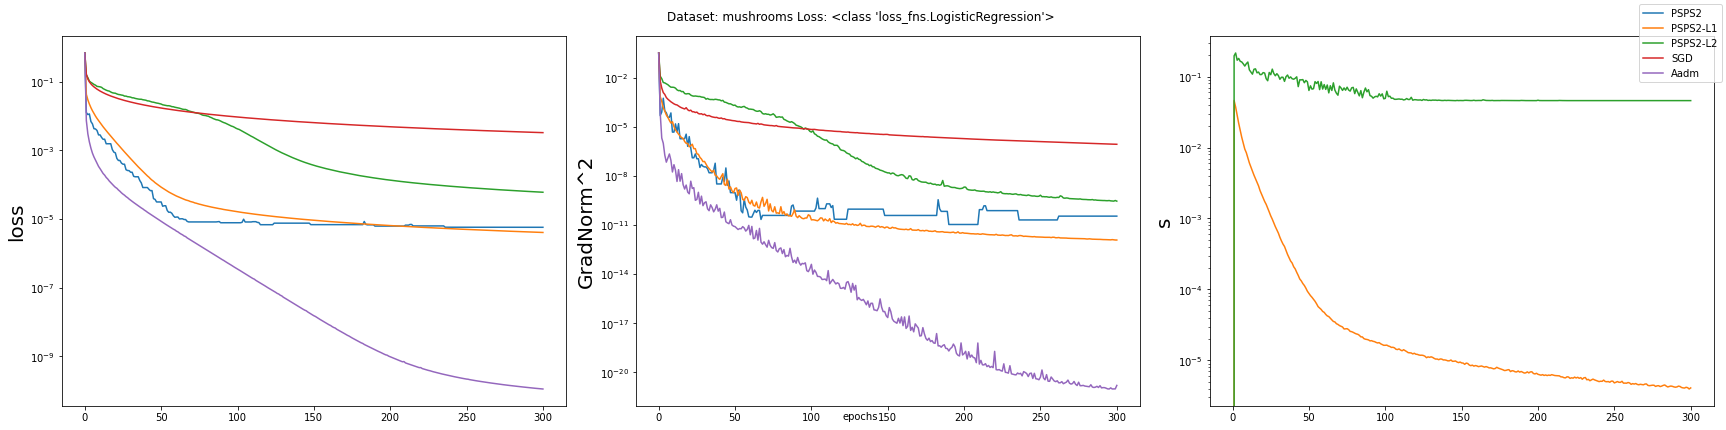

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))


ax1.semilogy([x[0] for x in hist_psps2])
ax1.semilogy([x[0] for x in hist_psps2_l1])
ax1.semilogy([x[0] for x in hist_psps2_l2])
ax1.semilogy([x[0] for x in hist_sgd])
ax1.semilogy([x[0] for x in hist_adam])


ax2.semilogy([x[1] for x in hist_psps2])
ax2.semilogy([x[1] for x in hist_psps2_l1])
ax2.semilogy([x[1] for x in hist_psps2_l2])
ax2.semilogy([x[1] for x in hist_sgd])
ax2.semilogy([x[1] for x in hist_adam])


ax3.semilogy([0 for x in hist_psps2])
ax3.semilogy([x[2] for x in hist_psps2_l1])
ax3.semilogy([x[2] for x in hist_psps2_l2])
ax3.semilogy([0 for x in hist_sgd])
ax3.semilogy([0 for x in hist_adam])


ax1.set_ylabel('loss', fontsize=20)
ax2.set_ylabel('GradNorm^2', fontsize=20)
ax3.set_ylabel('s', fontsize=20)

fig.text(0.5, 0.04, 'epochs', ha='center', va='center', )
fig.suptitle(f"Dataset: {dataset_name} Loss: {loss_class}")
fig.legend(['PSPS2', 'PSPS2-L1', 'PSPS2-L2', 'SGD', 'Aadm'])
plt.tight_layout()
fig.show()

# fig.savefig(f"../plots/psps2_{dataset_name}_logreg_scale:{scale_range}.png")

# NN

In [16]:
import torch
import numpy as np

from torch.utils.data import DataLoader
import torch.utils.data as data_utils

from torch.optim import SGD, Adam

import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'

from datasets import get_dataset

from loss_fns import LogisticRegression, NLLSQ
from optimizers import SPS

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
from utils import Hutch
from torch.optim import Optimizer

class SPS2(Optimizer):

    def __init__(self, params, preconditioner="none", slack_method="none", lmd=0.01, mu=0.1):
        defaults = dict(s=0.0)
        self.lmd = lmd
        self.lmd_hat = 1.0 / (1.0 + self.lmd)
        
        self.s = 0.0
        self.mu = mu
        self.delta = lmd + mu
        
        if slack_method == "L1":
            self.update = self.update_L1
        elif slack_method == "L2":
            self.update = self.update_L2
        else:
            self.update = self.update_sps

        self.preconditioner = None
        if preconditioner == "hutch":
            self.preconditioner = Hutch()
            
        self.preconditioner_initialized = False

        # TO-DO: Think of something better
        self.replay_buffer = []

        super().__init__(params, defaults)


    def step(self, closure=None):
        for group in self.param_groups:
            weights = list(group["params"])
            
            loss = closure()
            grad = torch.autograd.grad(loss, weights, create_graph=True)
            loss = loss.item()

            if self.preconditioner:
                if not self.preconditioner_initialized:
                    self.preconditioner.init(self, grad, 100)
                    self.preconditioner_initialized = True
                self.preconditioner.step(self, grad, 1)
            else:
                self.init_empty_precond()
                self.preconditioner_initialized = True
            
            gnorm_square = self.calc_grad_norm(grad).item()
            
            if gnorm_square < 1e-13:
                continue 

            self.update(gnorm_square, loss)

            self.replay_buffer.append({
                "loss": loss,
                "grad_norm_sq": gnorm_square,
                "slack": self.s,
            }) 
                          
        return loss

    @torch.no_grad()
    def update_sps(self, gnorm_square, loss):

        det = 1 - (2 * loss / gnorm_square )
        if det < 1e-15:
            return
        else:
            t = torch.sqrt(det)/det
            root1 = -1 + t
            root2 = -1 - t
            root = torch.maximum(root1, root2)
            precond = root/(1 + root)

        for group in self.param_groups: 
            for p in group['params']:
                p.sub_(self.state[p]['scaled_grad'].mul(precond))
    

    @torch.no_grad()
    def update_L1(self, gnorm_square, loss):

            s_nil = self.s - (self.lmd/(2*self.mu))
            z = self.s - s_nil

            t = loss - s_nil
            AA = 1
            BB = 2 + self.mu * gnorm_square - 2 * self.mu * t
            CC = 1 + 2 * self.mu * gnorm_square - 4 * self.mu * t
            DD = -2 * self.mu * t

            roots = solve(AA, BB, CC, DD)
            roots = torch.from_numpy(roots)
            root_star = torch.relu(torch.max(roots))

            self.s = torch.relu(self.s - ((self.lmd - root_star)/2 * self.mu)).item()
            
            precond = root_star/(1 + root_star)

            for group in self.param_groups:
                for p in group['params']:
                    p.sub_(self.state[p]['scaled_grad'].mul(precond))

    @torch.no_grad()
    def update_L2(self, gnorm_square ,loss):
        s_nil = self.s - (self.lmd/(2*self.mu))
        z = self.s - s_nil

        t = loss - s_nil

        AA = 1
        BB = 2 + self.delta * gnorm_square - 2 * self.delta * t
        CC = 1 + 2 * self.delta * gnorm_square - 4 * self.delta * t
        DD = -2 * self.delta * t

        roots = solve(AA, BB, CC, DD)
        roots = torch.from_numpy(roots)       
        root_star = torch.relu(torch.max(roots))

        self.s = (1/(self.delta)) * (self.mu * self.s + (root_star/2)).item()

        precond = root_star/(1 + root_star) 
        
        for group in self.param_groups: 
            for p in group['params']:
                p.sub_(self.state[p]['scaled_grad'].mul(precond))
            

    def init_empty_precond(self):
        for group in self.param_groups:
            for p in group['params']:
                self.state[p]['Dk'] = torch.ones_like(p) 
                self.state[p]['DkhatInv'] = torch.ones_like(p)

    def calc_grad_norm(self, grad):
        for group in self.param_groups: 
            gnorm_square = 0.
            for p, g in zip(group['params'], grad):
                g_detached = g.detach().clone()
                self.state[p]['scaled_grad'] = self.state[p]['DkhatInv'].mul(g_detached)
                gnorm_sq = self.state[p]['scaled_grad'].mul(g_detached).sum()
                gnorm_square += gnorm_sq

        return gnorm_square

In [18]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.ToTensor()])
BS = 128
trainset = torchvision.datasets.MNIST(root='../datasets', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=BS, shuffle=False)

testset = torchvision.datasets.MNIST(root='../datasets', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

In [19]:
from nn_models import SmallLeNet
from torch.functional import F

torch.random.manual_seed(0)
model = SmallLeNet().to(device)

w0 = [w+0.0 for w in model.parameters()]
d = np.sum([w.numel() for w in model.parameters()])
print ("Total parameters",d)  

Total parameters 970


In [20]:
@torch.no_grad()
def eval_model(model, loss_fn, data_loader):
    n_correct = 0
    n_samples = 0
    loss = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss += loss_fn(outputs, labels).item() / len(data_loader)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()  
    
    acc = 100.0 * n_correct / n_samples

    return loss, acc

In [21]:
def train_nn(model, criterion, train_loader, test_loader, epochs, optimizer_class, **optimizer_kwargs):

    optimizer = optimizer_class(model.parameters(), **optimizer_kwargs)

    slack = 0

    hist = []
    with torch.no_grad():
        train_loss, train_acc = eval_model(model, criterion, train_loader) 
        print(f"Epoch[{0}] Train Loss: {train_loss} | Train Acc: {train_acc}")

        test_loss, test_acc = eval_model(model, criterion, test_loader)
        print(f"Epoch[{0}] Test Loss: {test_loss} | Test Acc: {test_acc}")

        hist.append([train_loss, train_acc, test_loss, test_acc, slack])
        
    for epoch in range(epochs):
        for i, (images, labels) in enumerate(train_loader):  
            
            # images = images.reshape(-1, images.shape[2] * images.shape[3]).to(device)
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            def closure():
                outputs = model(images)
                return criterion(outputs, labels)
            
            loss = closure()

            if isinstance(optimizer, SPS2):     
                optimizer.step(closure) 
                slack = optimizer.replay_buffer[-1]["slack"]
            else:
                loss.backward()
                optimizer.step()

        if epoch % 10 == 0:
            with torch.no_grad():
                train_loss, train_acc = eval_model(model, criterion, train_loader) 
                print(f"Epoch[{epoch + 1}] Train Loss: {train_loss} | Train Acc: {train_acc}")

                test_loss, test_acc = eval_model(model, criterion, test_loader)
                print(f"Epoch[{epoch + 1}] Test Loss: {test_loss} | Test Acc: {test_acc}")

                hist.append([train_loss, train_acc, test_loss, test_acc, slack])
        
    return hist

In [22]:
EPOCHS = 100

In [25]:
model = SmallLeNet().to(device)
%prun train_nn(model, F.nll_loss, train_loader, test_loader, EPOCHS, SPS2, preconditioner="hutch", slack_method="L1")

Epoch[0] Train Loss: 2.3019664888816433 | Train Acc: 12.926666666666666
Epoch[0] Test Loss: 6.876575052773815 | Test Acc: 12.926666666666666
Epoch[1] Train Loss: 2.3014224280354996 | Train Acc: 10.441666666666666
Epoch[1] Test Loss: 6.874949800946807 | Test Acc: 10.441666666666666
Epoch[11] Train Loss: 2.301307879455556 | Train Acc: 11.236666666666666
Epoch[11] Test Loss: 6.874607614424554 | Test Acc: 11.236666666666666
Epoch[21] Train Loss: 0.662201900174952 | Train Acc: 77.72666666666667
Epoch[21] Test Loss: 1.978170007528996 | Test Acc: 77.72666666666667
Epoch[31] Train Loss: 0.22736503590059448 | Train Acc: 93.08333333333333
Epoch[31] Test Loss: 0.6791987378176987 | Test Acc: 93.08333333333333
Epoch[41] Train Loss: 0.15938084733383004 | Train Acc: 95.13333333333334
Epoch[41] Test Loss: 0.4761122127360913 | Test Acc: 95.13333333333334
Epoch[51] Train Loss: 0.14485859505780754 | Train Acc: 95.44
Epoch[51] Test Loss: 0.43273045275230404 | Test Acc: 95.44
Epoch[61] Train Loss: 0.138828

         625699200 function calls (617806890 primitive calls) in 4025.573 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   161458 2893.137    0.018 2893.137    0.018 {method 'item' of 'torch._C._TensorBase' objects}
    93900  242.704    0.003  242.704    0.003 {method 'run_backward' of 'torch._C._EngineBase' objects}
  7320000   67.734    0.000  472.331    0.000 functional.py:106(to_tensor)
  7696000   62.983    0.000   62.983    0.000 {method 'div' of 'torch._C._TensorBase' objects}
14686900/7366900   62.568    0.000  183.509    0.000 {built-in method numpy.array}
  7434436   61.682    0.000   61.682    0.000 {method 'to' of 'torch._C._TensorBase' objects}
  7320000   57.504    0.000  695.423    0.000 mnist.py:130(__getitem__)
  7320000   36.919    0.000  140.286    0.000 Image.py:2764(fromarray)
  7320000   27.368    0.000   80.192    0.000 Image.py:694(tobytes)
  7320000   21.691    0.000   21.691    0.000 {method 'vi

In [37]:

torch.random.manual_seed(42)

model = SmallLeNet().to(device)

small_lenet_sgd = train_nn(
    model, 
    F.nll_loss,
    train_loader,
    test_loader,
    EPOCHS,
    SGD,
    lr=0.01
)

Epoch[0] Train Loss: 2.3069560328657155 | Train Acc: 9.751666666666667
Epoch[0] Test Loss: 6.891480123656184 | Test Acc: 9.751666666666667
Epoch[1] Train Loss: 2.3034729687890527 | Train Acc: 9.751666666666667
Epoch[1] Test Loss: 6.881075301669206 | Test Acc: 9.751666666666667
Epoch[11] Train Loss: 2.2993483481158776 | Train Acc: 11.236666666666666
Epoch[11] Test Loss: 6.868753982588193 | Test Acc: 11.236666666666666
Epoch[21] Train Loss: 1.1616235388869802 | Train Acc: 63.48
Epoch[21] Test Loss: 3.47007286457321 | Test Acc: 63.48
Epoch[31] Train Loss: 0.5999340752588639 | Train Acc: 81.22166666666666
Epoch[31] Test Loss: 1.7921597534802975 | Test Acc: 81.22166666666666
Epoch[41] Train Loss: 0.44289743806796494 | Train Acc: 85.97333333333333
Epoch[41] Test Loss: 1.323050308623411 | Test Acc: 85.97333333333333
Epoch[51] Train Loss: 0.3666342368423777 | Train Acc: 88.42
Epoch[51] Test Loss: 1.0952322106947463 | Test Acc: 88.42
Epoch[61] Train Loss: 0.28845369996063447 | Train Acc: 90.968

In [39]:
torch.random.manual_seed(42)

model = SmallLeNet().to(device)

small_lenet_adam = train_nn(
    model, 
    F.nll_loss,
    train_loader,
    test_loader,
    EPOCHS,
    Adam,
    lr=0.01
)

Epoch[0] Train Loss: 2.3069560328657155 | Train Acc: 9.751666666666667
Epoch[0] Test Loss: 6.891480123656184 | Test Acc: 9.751666666666667
Epoch[1] Train Loss: 0.4315668099918042 | Train Acc: 86.65
Epoch[1] Test Loss: 1.2892027636060899 | Test Acc: 86.65
Epoch[11] Train Loss: 0.2960347473971168 | Train Acc: 90.86833333333334
Epoch[11] Test Loss: 0.884333098912407 | Test Acc: 90.86833333333334
Epoch[21] Train Loss: 0.2732307922834956 | Train Acc: 91.53333333333333
Epoch[21] Test Loss: 0.8162117298150281 | Test Acc: 91.53333333333333
Epoch[31] Train Loss: 0.2519844343288064 | Train Acc: 92.07666666666667
Epoch[31] Test Loss: 0.7527433101924224 | Test Acc: 92.07666666666667
Epoch[41] Train Loss: 0.2385178731775062 | Train Acc: 92.48166666666667
Epoch[41] Test Loss: 0.7125151752882187 | Test Acc: 92.48166666666667
Epoch[51] Train Loss: 0.23594708019087388 | Train Acc: 92.53333333333333
Epoch[51] Test Loss: 0.704835545283566 | Test Acc: 92.53333333333333
Epoch[61] Train Loss: 0.234936007239

In [26]:
torch.random.manual_seed(42)

model = SmallLeNet().to(device)

small_lenet_sps_l1_d = train_nn(
    model, 
    F.nll_loss,
    train_loader,
    test_loader,
    EPOCHS,
    SPS2,
    preconditioner="hutch",
    slack_method="L1"
)

Epoch[0] Train Loss: 2.3069560328657155 | Train Acc: 9.751666666666667
Epoch[0] Test Loss: 6.891480123656184 | Test Acc: 9.751666666666667
Epoch[1] Train Loss: 0.8981172030557297 | Train Acc: 71.255
Epoch[1] Test Loss: 2.682910625688772 | Test Acc: 71.255


KeyboardInterrupt: 

In [41]:
torch.random.manual_seed(42)

model = SmallLeNet().to(device)

small_lenet_sps_l2_d = train_nn(
    model, 
    F.nll_loss,
    train_loader,
    test_loader,
    EPOCHS,
    SPS2,
    preconditioner="hutch",
    slack_method="L2"
)

Epoch[0] Train Loss: 2.3069560328657155 | Train Acc: 9.751666666666667
Epoch[0] Test Loss: 6.891480123656184 | Test Acc: 9.751666666666667
Epoch[1] Train Loss: 0.842130427713662 | Train Acc: 72.07166666666667
Epoch[1] Test Loss: 2.515663506991766 | Test Acc: 72.07166666666667


KeyboardInterrupt: 

In [42]:
torch.random.manual_seed(42)

model = SmallLeNet().to(device)

small_lenet_sps_l1 = train_nn(
    model, 
    F.nll_loss,
    train_loader,
    test_loader,
    EPOCHS,
    SPS2,
    preconditioner="none",
    slack_method="L1"
)

Epoch[0] Train Loss: 2.3069560328657155 | Train Acc: 9.751666666666667
Epoch[0] Test Loss: 6.891480123656184 | Test Acc: 9.751666666666667
Epoch[1] Train Loss: 2.300363980207623 | Train Acc: 11.236666666666666
Epoch[1] Test Loss: 6.871787940875 | Test Acc: 11.236666666666666
Epoch[11] Train Loss: 1.8784015689477014 | Train Acc: 41.638333333333335
Epoch[11] Test Loss: 5.611276024436133 | Test Acc: 41.638333333333335


KeyboardInterrupt: 